<a href="https://colab.research.google.com/github/chltjs1921/2024_modeling_practice/blob/main/DTI_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))

Torch version:2.3.1+cu121
cuda version: 12.1
cudnn version:8902


In [ ]:
!pip install rdkit-pypi
!pip install lifelines
#!pip install dgl-cu121 dglgo -f https://data.dgl.ai/wheels/repo.html #cuda version 필히 확인할 것 https://www.dgl.ai/pages/start.html 참조
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html
!pip install dgllife
!pip install PyTDC

Looking in links: https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html


In [ ]:
import os
import pandas as pd
import json
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!unzip '/content/drive/MyDrive/FastCampus/Medical/Part 4/실습/DAVIS.zip' -d '/content/drive/MyDrive/FastCampus/Medical/Part 4/실습/'

Archive:  /content/drive/MyDrive/FastCampus/Medical/Part 4/실습/DAVIS.zip
   creating: /content/drive/MyDrive/FastCampus/Medical/Part 4/실습/DAVIS/
  inflating: /content/drive/MyDrive/FastCampus/Medical/Part 4/실습/DAVIS/affinity.txt  
  inflating: /content/drive/MyDrive/FastCampus/Medical/Part 4/실습/__MACOSX/DAVIS/._affinity.txt  
  inflating: /content/drive/MyDrive/FastCampus/Medical/Part 4/실습/DAVIS/SMILES.txt  
  inflating: /content/drive/MyDrive/FastCampus/Medical/Part 4/실습/__MACOSX/DAVIS/._SMILES.txt  
  inflating: /content/drive/MyDrive/FastCampus/Medical/Part 4/실습/DAVIS/target_seq.txt  
  inflating: /content/drive/MyDrive/FastCampus/Medical/Part 4/실습/__MACOSX/DAVIS/._target_seq.txt  


In [ ]:
affinity = pd.read_csv('/content/drive/MyDrive/FastCampus/Medical/Part 4/실습/DAVIS/affinity.txt', header=None, sep=' ')
affinity.head()

,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,441
0,43.0,10000.0,10000.0,10000.0,10000.00,10000.0,10000.0,10000.0,10000.0,10000.00,...,10000,10000,10000,10000,10000,10000.0,10000,230.0,10000.0,10000
1,10000.0,10000.0,10000.0,10000.0,10000.00,10000.0,10000.0,10000.0,10000.0,10000.00,...,10000,10000,10000,10000,10000,10000.0,10000,2000.0,10000.0,10000
2,10000.0,75.0,1.9,13.0,0.77,13.0,2.6,31.0,34.0,0.93,...,10000,10000,10000,10000,10000,260.0,1200,120.0,2.3,10000
3,10000.0,10000.0,10000.0,10000.0,10000.00,10000.0,10000.0,10000.0,10000.0,10000.00,...,10000,10000,10000,10000,10000,10000.0,10000,10000.0,10000.0,10000
4,10000.0,420.0,2900.0,750.0,580.00,230.0,500.0,500.0,1200.0,790.00,...,10000,10000,10000,10000,10000,10000.0,10000,10000.0,10000.0,10000


In [ ]:
with open('/content/drive/MyDrive/FastCampus/Medical/Part 4/실습/DAVIS/target_seq.txt') as f:
    target = json.load(f)
    target = list(target.values())

In [ ]:
with open('/content/drive/MyDrive/FastCampus/Medical/Part 4/실습/DAVIS/SMILES.txt') as f:
    drug = json.load(f)
    drug = list(drug.values())

In [ ]:
affinity.shape, len(target), len(drug)

((68, 442), 442, 68)

In [ ]:
affinity.describe()

,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,441
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,...,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,6305.710294,4786.038882,6776.396029,6157.742956,5368.200176,5076.213941,3662.326721,4603.582397,4621.454015,4351.749309,...,8199.426471,9174.279412,8509.647059,8989.588235,9681.838235,5118.126471,8046.602941,3241.946765,6886.200000,8798.838235
std,4502.267160,4755.621867,4071.977775,4317.135465,4538.166881,4586.191949,4403.584967,4605.842183,4752.974206,4717.341321,...,3384.862965,2458.183712,3181.048615,2741.635062,1683.615935,4627.492704,3430.533809,4272.287089,4264.491886,2973.932873
min,1.200000,0.047000,0.100000,0.041000,0.032000,0.019000,0.025000,0.046000,0.016000,0.037000,...,71.000000,57.000000,13.000000,24.000000,55.000000,0.300000,12.000000,0.520000,2.300000,16.000000
25%,892.500000,123.750000,2775.000000,1075.000000,632.500000,270.000000,45.000000,64.000000,59.000000,99.250000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,260.000000,7100.000000,50.250000,1775.000000,10000.000000
50%,10000.000000,2050.000000,10000.000000,10000.000000,4250.000000,2800.000000,960.000000,2500.000000,1800.000000,865.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,4350.000000,10000.000000,490.000000,10000.000000,10000.000000
75%,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
max,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000


In [ ]:
print(target[0])
print(drug[0])

MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL
CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(C

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
SMILES = []
Target_seq = []
y = []

for i in range(len(drug)):
    for j in range(len(target)):
        SMILES.append(drug[i])
        Target_seq.append(target[j])
        y.append(affinity.values[i,j])

In [ ]:
th = 300

y = [1 if i else 0 for i in np.array(y) < th]

In [ ]:
All_data_dic = {'SMILES':SMILES, 'Target_seq':Target_seq, 'y':y}
All_data_df = pd.DataFrame(All_data_dic)

In [ ]:
All_data_df

,SMILES,Target_seq,y
0,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,1
1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0
2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0
3,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0
4,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0
...,...,...,...
30051,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MGCIKSKENKSPAIKYRPENTPEPVSTSVSHYGAEPTTVSPCPSSS...,0
30052,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MAHLRGFANQHSRVDPEELFTKLDRIGKGSFGEVYKGIDNHTKEVV...,0
30053,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,0
30054,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MSSLGASFVQIKFDDLQFFENCGGGSFGSVYRAKWISQDKEVAVKK...,0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0, 0.5, 'counts')

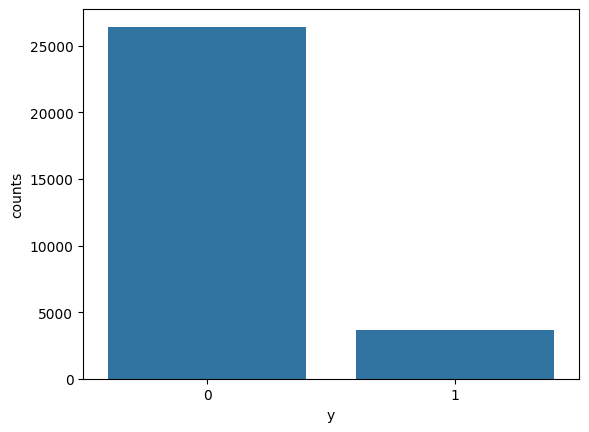

In [ ]:
counts = All_data_df['y'].value_counts()

x = np.array([0,1])

ax = plt.subplot()
sns.barplot(counts, ax=ax)
ax.set_xticks(x)

plt.xlabel('y')
plt.ylabel('counts')

In [ ]:
# 아미노산 charater 정의
amino_char = ['?', 'A', 'C', 'B', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'O',
       'N', 'Q', 'P', 'S', 'R', 'U', 'T', 'W', 'V', 'Y', 'X', 'Z']

# protein, drug 원핫(one-hot) 인코더
enc_protein = OneHotEncoder().fit(np.array(amino_char).reshape(-1, 1))

# Protein 최대 길이
MAX_SEQ_PROTEIN = 1000

In [ ]:
def trans_protein(x):
    temp = list(x.upper())
    temp = [i if i in amino_char else '?' for i in temp]

    if len(temp) < MAX_SEQ_PROTEIN:
        temp += ['?'] * (MAX_SEQ_PROTEIN - len(temp))
    else:
        temp = temp[:MAX_SEQ_PROTEIN]

    return temp

In [ ]:
AA = pd.Series(All_data_df['Target_seq'].unique()).apply(trans_protein)

AA_dict = dict(zip(All_data_df['Target_seq'].unique(), AA))

All_data_df['Target_encodings'] = [AA_dict[i] for i in All_data_df['Target_seq']]

In [ ]:
def create_fold(df, fold_seed, frac):

    train_frac, val_frac, test_frac = frac

    test = df.sample(frac=test_frac, random_state=fold_seed, replace=False)
    train_val = df.drop(test.index)

    val = train_val.sample(frac=val_frac/(train_frac+val_frac), random_state=fold_seed, replace=False)
    train = train_val.drop(val.index)

    return train, val, test

In [ ]:
train, val, test = create_fold(All_data_df, 42, [0.7, 0.1, 0.2])

In [ ]:
len(train), len(val), len(test)

(21039, 3006, 6011)

In [ ]:
train

,SMILES,Target_seq,y,Target_encodings
0,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,1,"[M, K, K, F, F, D, S, R, R, E, Q, G, G, S, G, ..."
1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[P, F, W, K, I, L, N, P, L, L, E, R, G, T, Y, ..."
2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[P, F, W, K, I, L, N, P, L, L, E, R, G, T, Y, ..."
3,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[P, F, W, K, I, L, N, P, L, L, E, R, G, T, Y, ..."
4,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[P, F, W, K, I, L, N, P, L, L, E, R, G, T, Y, ..."
...,...,...,...,...
30050,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MRSGAERRGSSAAASPGSPPPGRARPAGSDAPSALPPPAAGQPRAR...,0,"[M, R, S, G, A, E, R, R, G, S, S, A, A, A, S, ..."
30052,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MAHLRGFANQHSRVDPEELFTKLDRIGKGSFGEVYKGIDNHTKEVV...,0,"[M, A, H, L, R, G, F, A, N, Q, H, S, R, V, D, ..."
30053,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,0,"[M, S, S, M, P, K, P, E, R, H, A, E, S, L, L, ..."
30054,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MSSLGASFVQIKFDDLQFFENCGGGSFGSVYRAKWISQDKEVAVKK...,0,"[M, S, S, L, G, A, S, F, V, Q, I, K, F, D, D, ..."


In [ ]:
def protein_2_embed(x):
    return enc_protein.transform(np.array(x).reshape(-1, 1)).toarray().T

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from torch.utils import data
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from functools import partial
import dgl

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
class data_process_loader(Dataset):
    def __init__(self, df):
        self.df = df

        self.node_featurizer = CanonicalAtomFeaturizer()
        self.edge_featurizer = CanonicalBondFeaturizer(self_loop=True)

        self.fc = partial(smiles_to_bigraph, add_self_loop=True)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        v_d = self.df.iloc[idx]['SMILES']
        v_d = self.fc(smiles=v_d, node_featurizer=self.node_featurizer, edge_featurizer=self.edge_featurizer)

        v_p = self.df.iloc[idx]['Target_encodings']
        v_p = protein_2_embed(v_p)

        y = self.df.iloc[idx]['y']

        return v_d, v_p, y

        return v_d, v_p, v_y

In [ ]:
train_dataset = data_process_loader(train)
val_dataset = data_process_loader(val)
test_dataset = data_process_loader(test)

In [ ]:
for (v_d, v_p, y) in train_dataset:
    print(v_d)
    print(v_p)
    print(y)
    break

Graph(num_nodes=27, num_edges=87,
      ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(13,), dtype=torch.float32)})
[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1


In [ ]:
print(v_d.ndata['h'].shape)
print(v_d.ndata['h'])

torch.Size([27, 74])
tensor([[1., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
print(v_d.edata['e'].shape)
print(v_d.edata['e'])

torch.Size([87, 13])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [ ]:
v_d.batch_size

1

In [ ]:
def dgl_collate_fun(x):
    v_d, v_p, y = zip(*x)

    v_d = dgl.batch(v_d)
    v_p = torch.FloatTensor(v_p)
    y = torch.FloatTensor(y)

    return v_d, v_p, y

In [ ]:
params = {'batch_size': 256,
            'shuffle': True,
            'num_workers': 0,
            'drop_last': False,
          'collate_fn' : dgl_collate_fun}

train_loader = DataLoader(train_dataset, **params)
val_loader = DataLoader(val_dataset, **params)
test_loader = DataLoader(test_dataset, **params)

In [ ]:
for v_d, v_p, y in train_loader:
    print(v_d)
    print(v_p)
    print(y)

    drug_demo = v_d
    protein_demo = v_p
    y_demo = y

    break

Graph(num_nodes=8487, num_edges=27271,
      ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(13,), dtype=torch.float32)})
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  .

In [ ]:
import torch.nn.functional as F
from torch import nn
from dgllife.model.gnn.gcn import GCN
from dgllife.model.readout.weighted_sum_and_max import WeightedSumAndMax

In [ ]:
config = {
    # drug 설정
    "gnn_hid_dim_drug" : 64,
    "gnn_num_layers" : 3,
    "gnn_activation" : F.relu,
    "hidden_dim_drug" : 256,
    "cls_hidden_dims" : [1024, 1024, 512],

    # protein 설정
    "cnn_target_filters" : [32,64,96],
    "cnn_target_kernels" : [4,8,12],
    "hidden_dim_protein" : 256,
    "rnn_target_hid_dim" : 64,
    "rnn_target_n_layers" : 2,
    "rnn_target_bidirectional" : True,
    "rnn_Use_GRU_LSTM_target" : 'GRU',

    # Classfier 설정
    "cls_hidden_dims" : [1024, 1024, 512]
    }

In [ ]:
class CNN_RNN(nn.Sequential):
    def __init__(self, encoding, **config):
        super(CNN_RNN, self).__init__()

        if encoding == 'drug':
            hidden_dim = [config['gnn_hid_dim_drug']]*config['gnn_num_layers']
            activation = [config['gnn_activation']]*config['gnn_num_layers']
            predictor_dim = config['hidden_dim_drug']

            self.gnn = GCN(in_feats=74, hidden_feats=hidden_dim, activation=activation)

            gnn_out_feats = self.gnn.hidden_feats[-1]
            self.readout = WeightedSumAndMax(gnn_out_feats)
            self.transform = nn.Linear(gnn_out_feats*2, predictor_dim)

        if encoding == 'protein':

            in_ch = [26]+config['cnn_target_filters']
            self.in_ch = in_ch[-1]

            kernel_size = config['cnn_target_kernels']

            layer_size = len(config['cnn_target_filters'])

            self.cnn = nn.ModuleList([nn.Conv1d(in_ch[i], in_ch[i+1], kernel_size[i]) for i in range(layer_size)]).double()

            n_size_p = self._get_conv_output((26, 1000))

            if config['rnn_Use_GRU_LSTM_target'] == 'LSTM':
                self.rnn = nn.LSTM(in_ch[-1], config['rnn_target_hid_dim'], config['rnn_target_n_layers'],batch_first=True,
                                  bidirectional=config['rnn_target_bidirectional'])

            elif config['rnn_Use_GRU_LSTM_target'] == 'GRU':
                self.rnn = nn.GRU(in_ch[-1], config['rnn_target_hid_dim'], config['rnn_target_n_layers'],batch_first=True,
                                  bidirectional=config['rnn_target_bidirectional'])

            else:
                raise ValueError('Please use LSTM or GRU')

            direction = 2 if config['rnn_target_bidirectional'] else 1
            self.rnn = self.rnn.double()
            self.fc1 = nn.Linear(n_size_p*direction*config['rnn_target_hid_dim'], config['hidden_dim_protein'])

        self.encoding = encoding
        self.config = config

    def _get_conv_output(self, shape):
        batch_size = 1
        input = Variable(torch.rand(batch_size, *shape))
        output_feat = self._forward_features(input.double())
        n_size = output_feat.data.view(batch_size, self.in_ch, -1).size(2)
        return n_size

    def _forward_features(self, x):
        for l in self.cnn:
            x = F.relu(l(x))
        return x

    def forward(self, v):

        if self.encoding == 'protein':
            v = self._forward_features(v.double())

            batch_size = v.size(0)
            v = v.view(batch_size, v.size(2), -1)
            if self.config['rnn_Use_GRU_LSTM_target'] == 'LSTM':
                direction = 2 if self.config['rnn_target_bidirectional'] else 1
                h0 = torch.randn(direction*self.config['rnn_target_n_layers'],
                                 batch_size, self.config['rnn_target_hid_dim']).to(device)
                c0 = torch.randn(direction*self.config['rnn_target_n_layers'],
                                 batch_size, self.config['rnn_target_hid_dim']).to(device)
                v, (hn, cn)= self.rnn(v.double(), (h0.double(), c0.double()))

            else:
                direction = 2 if self.config['rnn_target_bidirectional'] else 1
                h0 = torch.randn(direction*self.config['rnn_target_n_layers'],
                                 batch_size, self.config['rnn_target_hid_dim']).to(device)
                v, hn = self.rnn(v.double(), h0.double())
                v = torch.flatten(v, 1)
                v = self.fc1(v.float())
        else:
            feats = v.ndata.pop('h')
            node_feats = self.gnn(v, feats)
            v = self.readout(v, node_feats)
            v = self.transform(v)

        return v

In [ ]:
class Classifier(nn.Sequential):
    def __init__(self, model_drug, model_protein, **config):
        super(Classifier, self).__init__()

        self.input_dim_drug = config['hidden_dim_drug']
        self.input_dim_protein = config['hidden_dim_protein']

        self.model_drug = model_drug
        self.model_protein = model_protein

        self.dropout = nn.Dropout(0.1)

        self.hidden_dims = config['cls_hidden_dims']
        layer_size = len(self.hidden_dims) + 1

        dims = [self.input_dim_drug + self.input_dim_protein] + self.hidden_dims + [1]

        self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)])

    def forward(self, v_d, v_p):
        v_d = self.model_drug(v_d)
        v_p = self.model_protein(v_p)

        v_f = torch.cat([v_d, v_p], dim=1)

        for i, l in enumerate(self.predictor):
            if i == (len(self.predictor) - 1):
                v_f = l(v_f)
            else:
                v_f = F.relu(self.dropout(l(v_f)))

        return v_f

In [ ]:
model_drug = CNN_RNN('drug', **config)
model_protein = CNN_RNN('protein', **config)

In [ ]:
model = Classifier(model_drug, model_protein, **config)
model = model.to(device)

In [ ]:
import copy
from prettytable import PrettyTable
from time import time

from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, f1_score, log_loss

In [ ]:
lr = 0.001
weight_decay = 0.00001
epoch = 1

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.BCELoss()
sigmoid = nn.Sigmoid()

In [ ]:
def get_metrics(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    loss = log_loss(y_true, y_pred)

    return auc, ap, f1, loss

In [ ]:
loss_hist = []

max_auc = 0
model_max = copy.deepcopy(model)

valid_metric_record = []
valid_metric_header = ['epoch', 'auc', 'ap', 'f1', 'loss']

table = PrettyTable(valid_metric_header)

float2str = lambda x: '%.4f' % x

print('Start')
t_start = time()

for i in range(epoch):
    model.train()

    for i, (v_d, v_p, y) in enumerate(train_loader):
        v_d = v_d.to(device)
        v_p = v_p.float().to(device)
        #y = y.to(device)

        score = model(v_d, v_p)
        label = Variable(torch.from_numpy(np.array(y)).float()).to(device)
        n = torch.squeeze(sigmoid(score), 1)

        loss = criterion(n, label)
        loss_hist.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.set_grad_enabled(False):
        y_pred = []
        y_true = []

        for i, (v_d, v_p, y) in enumerate(val_loader):
            v_d = v_d.to(device)
            v_p = v_p.float().to(device)
            #y = y.to(device)

            score = model(v_d, v_p)

            logits = torch.squeeze(sigmoid(score), 1).detach().cpu().numpy()
            label_ids = y.to('cpu').numpy()
            y_pred += logits.flatten().tolist()
            y_true += label_ids.flatten().tolist()

        outputs = np.array([1 if i else 0 for i in np.asarray(y_pred) >= 0.5 ])

        auc, ap, f1, loss = get_metrics(y_true, outputs)

        lst = ['epoch' + str(epoch)] + list(map(float2str, [auc, ap, f1, loss]))
        valid_metric_record.append(lst)

        if auc > max_auc:
            max_auc = auc
            model_max = copy.deepcopy(model)

        print('Validation at Epoch' + str(epoch+1)+'AUROC'+str(auc)[:7]+
              'AUPR'+str(ap)[:7]+'F1'+str(f1)[:7]+'Loss'+str(loss)[:7])

        table.add_row(lst)

Start
Validation at Epoch2AUROC0.60307AUPR0.24296F10.33264Loss3.89693


In [ ]:
model.eval()

y_pred_test = []
y_label_test = []
y_outputs_test = []

for i, (v_d, v_p, y) in enumerate(test_loader):
    v_d = v_d.to(device)
    v_p = v_p.float().to(device)
    #y = y.to(device)

    score = model(v_d, v_p)
    logits = torch.squeeze(sigmoid(score)).detach().cpu().numpy()
    label_ids = y.to('cpu').numpy()
    y_pred_test += logits.flatten().tolist()
    y_label_test += label_ids.flatten().tolist()
    outputs_test = np.asarray([1 if i else 0 for i in np.asarray(y_pred_test) >= 0.5 ])
    y_outputs_test.append(outputs_test)

In [ ]:
print(len(y_outputs_test))
print(len(y_label_test))
print(len(outputs_test))

24
6011
6011


In [ ]:
auc, ap, f1, loss = get_metrics(y_label_test,  outputs_test)

print('Test AUROC'+str(auc)[:7]+'AUPR'+str(ap)[:7]+'F1'+str(f1)[:7]+'Loss'+str(loss)[:7])

Test AUROC0.60929AUPR0.23599F10.34375Loss3.77765


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [ ]:
def roccurve(y_pred, y_label):
    y_label = np.array(y_label)
    y_pred = np.array(y_pred)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr[0], tpr[0], _ = roc_curve(y_label, y_pred)
    roc_auc[0] = auc(fpr[0], tpr[0])

    lw = 2
    plt.plot(fpr[0], tpr[0], lw=lw, label=' (area = %0.2f)'% roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    fontsize = 14
    plt.xlabel('False Positive Rate', fontsize = fontsize)
    plt.ylabel('True Positive Rate', fontsize = fontsize)
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def pr_curve(y_pred, y_label, method_name):
    lr_precision, lr_recall, _ = precision_recall_curve(y_label, y_pred)

    plt.plot(lr_recall, lr_precision, lw=2, label=method_name+' (area = %0.2f)'% average_precision_score(y_label, y_pred))
    fontsize = 14
    plt.xlabel('Recall', fontsize = fontsize)
    plt.ylabel('Precision', fontsize = fontsize)
    plt.title('Precision Recall Curve')
    plt.legend()
    plt.show()

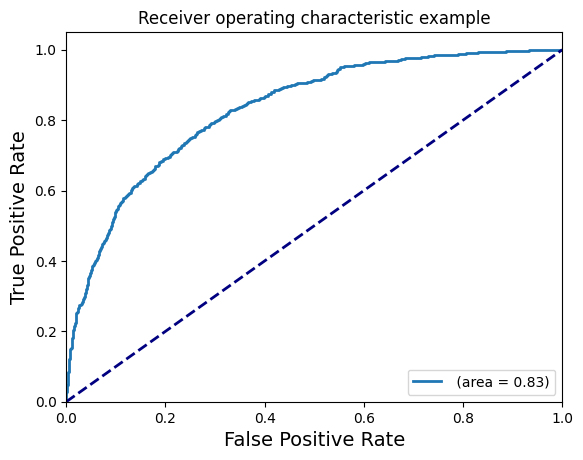

In [ ]:
roccurve(y_pred_test, y_label_test)

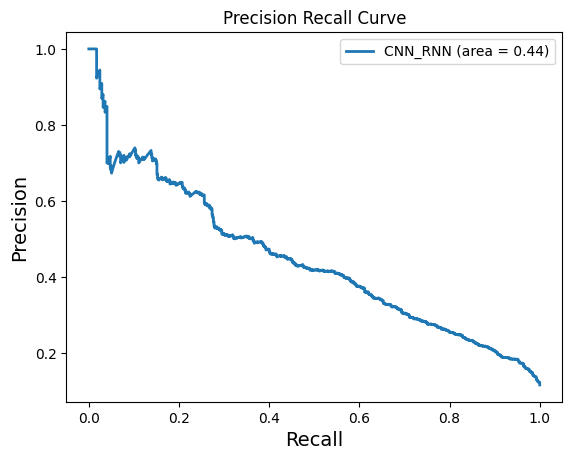

In [ ]:
pr_curve(y_pred_test, y_label_test, 'CNN_RNN')